## Grad-CAM Visualization for Melanoma Classification

### Purpose

In medical image classification tasks—particularly in dermatology—interpreting the reasoning behind a neural network's prediction is as important as the prediction itself. To increase the transparency and reliability of our melanoma classification model, we implemented **Grad-CAM (Gradient-weighted Class Activation Mapping)**.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import os
import random

from tensorflow.keras.models import load_model

if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
model_path = "/content/drive/My Drive/melonoma_classification_model/final_finetuned_model.keras"
model = load_model(model_path)
print("Model sucessfully loaded.")

Model sucessfully loaded.


🔬 Malignant örnekleri:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


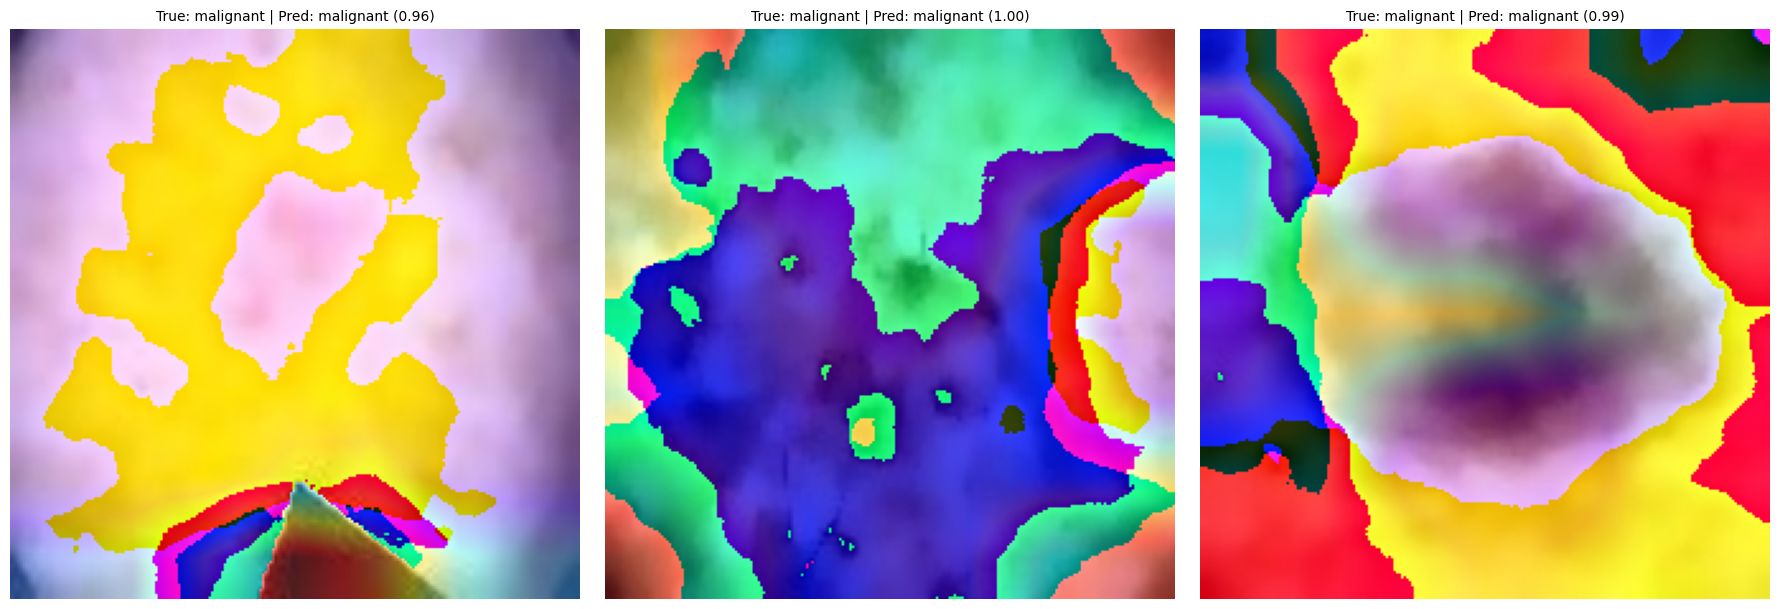


🧪 Benign örnekleri:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


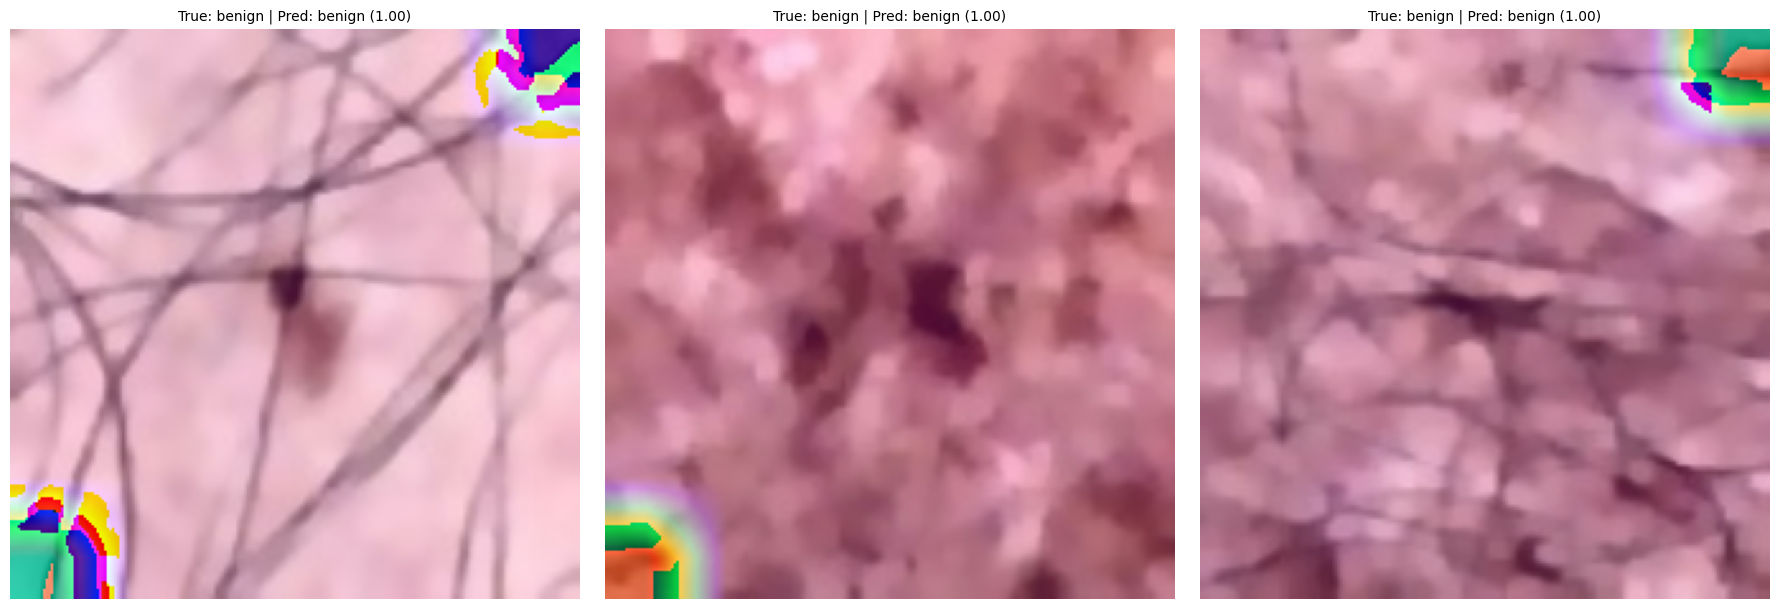

In [ ]:
# Calculating the Grad-cam image.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # Note: @ is matrix mult operator in new versions. Try run on vers>3.4
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function that enables the gradcam image view
def generate_gradcam_image(img_path, model, true_label):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_batch = np.expand_dims(img_array, axis=0)
    img_array_preprocessed = preprocess_input(img_array_batch)

    # Prediction result from image.
    prediction = model.predict(img_array_preprocessed)[0][0]
    predicted_label = "malignant" if prediction >= 0.5 else "benign"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model)

    # Meshup with the image+heatmap
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img_cv
    result = cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB)

    title = f"True: {true_label} | Pred: {predicted_label} ({confidence:.2f})"
    return result, title

# Displaying the rows of images.
def display_multiple_gradcams(image_paths, true_label, model):
    images = []
    titles = []
    for path in image_paths:
        img, title = generate_gradcam_image(path, model, true_label)
        images.append(img)
        titles.append(title)

    # This will lead a solution based on the 1x3 row display
    fig, axs = plt.subplots(1, len(images), figsize=(18, 6))
    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(titles[i], fontsize=10)
    plt.tight_layout()
    plt.show()

malignant_dir = '/content/drive/My Drive/melonoma_classification_dataset/test/malignant'
benign_dir = '/content/drive/My Drive/melonoma_classification_dataset/test/benign'

malignant_files = [os.path.join(malignant_dir, f) for f in os.listdir(malignant_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
benign_files = [os.path.join(benign_dir, f) for f in os.listdir(benign_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))]

random_malignant = random.sample(malignant_files, 3)
random_benign = random.sample(benign_files, 3)

# Displaying the gradcams.
display_multiple_gradcams(random_malignant, "malignant", model)

display_multiple_gradcams(random_benign, "benign", model)



## Clinical Interpretation of Grad-CAM Visualizations in Melanoma Classification

### Observational Insight

Through visual comparison of Grad-CAM heatmaps generated for benign and malignant lesions, a consistent spatial activation pattern emerges:

- In **benign lesions**, the model's attention tends to be:
  - **Centrally focused** around the lesion.
  - **Diffuse and softly distributed**, often forming a symmetric, rounded shape.
  - **Avoidant of image borders**, suggesting a local rather than global decision mechanism.

- In contrast, **malignant lesions** exhibit:
  - **Sharp, irregular and border-oriented activation** patterns.
  - **Multiple hotspots** across the lesion or even extending toward image edges.
  - A tendency to emphasize **asymmetric structures**, abrupt texture changes, or pigmented regions.

---

### Clinical Interpretation

These patterns align with dermatological diagnostic principles:

- **Benign lesions** are typically symmetrical, with smooth borders and uniform color. The AI model, mirroring clinical intuition, focuses its "attention" on the central homogeneous regions.

- **Malignant lesions**, such as melanomas, often have:
  - **Asymmetry**, irregular borders, and color variegation.
  - These features are reflected in the **chaotic, edge-heavy attention maps** produced by Grad-CAM.

This suggests the model has internalized diagnostic cues similar to the **"ABCDE"** clinical rule (Asymmetry, Border, Color, Diameter, Evolving).